## Preprocessing

In [1]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
import shap
import matplotlib.pyplot as plt
import tqdm
from timeit import default_timer as timer

from sklearn import metrics
from sklearn.model_selection import LeaveOneOut
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_validate

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
os.chdir('c:/users/fre_f/pythonprojects/bacteriological/')

In [3]:
df = pd.read_csv('./data/Genus_DESL.csv')

In [4]:
df.head()

,Index,DESL,Corynebacterium,Staphylococcus,Propionibacterium,sp50014,Moraxella,Blautia,sp50017,sp5276,...,Light treatment,OSDI score,DEQ5 score,TBUT OD,TBUT OS,OSS OD,OSS OS,ST OD,ST OS,Demodicosis
0,P1,3,0.092816,0.001058,0.042075,0.0,0.0,0.000000,0.0,0.000000,...,0,NaN,NaN,3,3,0,0,23,23,0
1,P2,3,0.698862,0.001191,0.004366,0.0,0.0,0.000000,0.0,0.000000,...,0,31.25,17.0,2,4,1,3,14,18,0
2,P3,2,0.034017,0.259365,0.003640,0.0,0.0,0.000000,0.0,0.000000,...,1,33.30,16.0,8,8,3,3,11,8,0
3,P4,3,0.029042,0.177362,0.015877,0.0,0.0,0.127216,0.0,0.000000,...,0,93.75,21.0,3,2,2,2,12,11,0
4,P5,1,0.307662,0.164086,0.050351,0.0,0.0,0.000331,0.0,0.000463,...,1,6.25,7.0,11,11,0,0,22,32,0


In [5]:
df.iloc[:,2:600]

,Corynebacterium,Staphylococcus,Propionibacterium,sp50014,Moraxella,Blautia,sp50017,sp5276,Finegoldia,Acinetobacter,...,Dyella,Actinopolymorpha,Trichococcus,melongena,Methylophilus,Murdochiella,Intrasporangium,sp10518,sp44151,Limnobacter
0,0.092816,0.001058,0.042075,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.006020,...,0,0.0,0.0,0,0.0,0.0,0.0,0,0,0
1,0.698862,0.001191,0.004366,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0,0.0,0.0,0,0.0,0.0,0.0,0,0,0
2,0.034017,0.259365,0.003640,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0,0.0,0.0,0,0.0,0.0,0.0,0,0,0
3,0.029042,0.177362,0.015877,0.000000,0.0,0.127216,0.0,0.000000,0.0,0.000000,...,0,0.0,0.0,0,0.0,0.0,0.0,0,0,0
4,0.307662,0.164086,0.050351,0.000000,0.0,0.000331,0.0,0.000463,0.0,0.002183,...,0,0.0,0.0,0,0.0,0.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0.358462,0.185519,0.108214,0.016877,0.0,0.000397,0.0,0.000000,0.0,0.000000,...,0,0.0,0.0,0,0.0,0.0,0.0,0,0,0
57,0.077600,0.355253,0.048227,0.000000,0.0,0.006814,0.0,0.036518,0.0,0.001125,...,0,0.0,0.0,0,0.0,0.0,0.0,0,0,0
58,0.296309,0.601019,0.004895,0.000000,0.0,0.004631,0.0,0.000000,0.0,0.000000,...,0,0.0,0.0,0,0.0,0.0,0.0,0,0,0
59,0.834877,0.046375,0.005028,0.000000,0.0,0.008997,0.0,0.004829,0.0,0.006285,...,0,0.0,0.0,0,0.0,0.0,0.0,0,0,0


In [6]:
df.iloc[:,1]

0     3
1     3
2     2
3     3
4     1
     ..
56    3
57    2
58    2
59    2
60    3
Name: DESL, Length: 61, dtype: int64

In [7]:
X = df.iloc[:,2:600]
y = df.iloc[:,1]

## Train, predict and explain

### XGBoost

In [8]:
le = LabelEncoder()
y_xgb = le.fit_transform(y)


clfxgb = XGBClassifier(random_state=42)
looxgb = LeaveOneOut()
xgb_scores = cross_validate(clfxgb, X, y_xgb, cv=looxgb, scoring='accuracy', return_estimator=True)


In [9]:
xgb_scores

{'fit_time': array([0.35037875, 0.33253789, 0.32920885, 0.32653356, 0.32753897,
        0.32358623, 0.32387614, 0.32804346, 0.30810261, 0.32229257,
        0.34088993, 0.32791543, 0.32741761, 0.32312131, 0.32590556,
        0.32377243, 0.32540607, 0.33197856, 0.33687568, 0.33694148,
        0.3362906 , 0.32985616, 0.32887697, 0.34908366, 0.34380245,
        0.33168912, 0.33107495, 0.33235097, 0.32767081, 0.32837415,
        0.33285642, 0.3287797 , 0.33318639, 0.33674765, 0.34003878,
        0.34580731, 0.32777095, 0.31810236, 0.32716465, 0.32936144,
        0.32579637, 0.325634  , 0.32574439, 0.32877183, 0.32808375,
        0.32735395, 0.32791233, 0.32581186, 0.3285358 , 0.32407165,
        0.327739  , 0.3228631 , 0.32610464, 0.32123065, 0.31353354,
        0.31446052, 0.32270384, 0.3172524 , 0.32406974, 0.32204318,
        0.32584167]),
 'score_time': array([0.06469297, 0.06366587, 0.06351638, 0.06351256, 0.06350946,
        0.06251192, 0.06600285, 0.0630002 , 0.05607057, 0.06351209,


In [10]:
feature_importances_complete = []

for idx, estimator in enumerate(xgb_scores['estimator']):
    print(f'The most important features for estimator {idx}:')
    feature_importances = pd.DataFrame(estimator.feature_importances_,
                                       index=X.columns,
                                       columns=['Importance']).sort_values('Importance', ascending=False)
    print(feature_importances)
    feature_importances_complete.append(feature_importances)

feature_importances_complete = pd.concat(feature_importances_complete)

The most important features for estimator 0:
                              Importance
Variovorax                      0.098368
BurkholderiaParaburkholderia    0.051287
sp35665                         0.048631
Cloacibacterium                 0.047529
sp30425                         0.042475
...                                  ...
sp35239                         0.000000
Aureimonas                      0.000000
Jatrophihabitans                0.000000
Lysinibacillus                  0.000000
Limnobacter                     0.000000

[598 rows x 1 columns]
The most important features for estimator 1:
                  Importance
Variovorax          0.067390
sp30425             0.061034
Aerococcus          0.060757
Lactococcus         0.053936
Cloacibacterium     0.053312
...                      ...
sp35190             0.000000
sp35239             0.000000
Aureimonas          0.000000
Jatrophihabitans    0.000000
Limnobacter         0.000000

[598 rows x 1 columns]
The most important fea

In [11]:
feature_importances_complete

,Importance
Variovorax,0.098368
BurkholderiaParaburkholderia,0.051287
sp35665,0.048631
Cloacibacterium,0.047529
sp30425,0.042475
...,...
Aureimonas,0.000000
Jatrophihabitans,0.000000
Lysinibacillus,0.000000
sp35669,0.000000


In [12]:
feature_importances_complete.shape

(36478, 1)

In [13]:
fic = feature_importances_complete.groupby(level=0).mean().sort_values('Importance', ascending=False)

In [14]:
fic[:15]

,Importance
Variovorax,0.074605
Cloacibacterium,0.051026
Comamonas,0.041495
sp30425,0.040010
Aerococcus,0.039681
Nitriliruptor,0.034739
BurkholderiaParaburkholderia,0.031745
Bradyrhizobium,0.031368
Lactococcus,0.030195
Microbacterium,0.029873


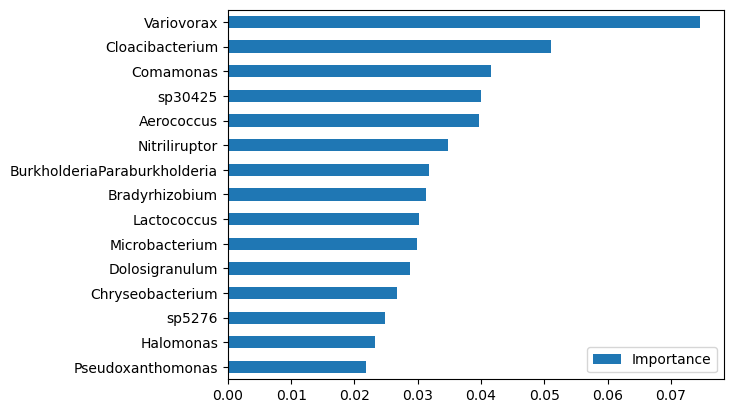

In [15]:

plot_fic = fic[:15]
plot_fic.plot(kind='barh').invert_yaxis()

In [24]:
# Calculate the SHAP values for every estimator 
shap_importances_complete_xgb = []

for idx, estimator in enumerate(xgb_scores['estimator']):
    xgbshap = estimator.fit(X, y_xgb)
    explainerxgb = shap.Explainer(xgbshap, X)
    shap_valuesxgb = explainerxgb.shap_values(X.iloc[:,:])
    shap_importances_complete_xgb.append(shap_valuesxgb)
    

[10:18:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[10:18:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[10:18:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[10:18:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-au

In [25]:
shap_importances_complete_xgb

[[array([[-0.18106302,  0.        , -0.20275525, ...,  0.        ,
           0.        ,  0.        ],
         [ 0.35397253,  0.        ,  0.16256849, ...,  0.        ,
           0.        ,  0.        ],
         [-0.1774067 ,  0.        ,  0.13476612, ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [-0.16072832,  0.        ,  0.1537201 , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.36549984,  0.        ,  0.1537201 , ...,  0.        ,
           0.        ,  0.        ],
         [-0.19535386,  0.        , -0.07452361, ...,  0.        ,
           0.        ,  0.        ]]),
  array([[-0.11075381, -0.65542992, -0.24158917, ...,  0.        ,
           0.        ,  0.        ],
         [-0.00528898, -0.37510478,  0.39082336, ...,  0.        ,
           0.        ,  0.        ],
         [ 0.0426113 ,  0.35543165,  0.52282488, ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [-0.01196745,  0.54892103

In [28]:
len(shap_importances_complete_xgb)

61

In [ ]:


for idx, estimator in enumerate(xgb_scores['estimator']):
    print(f'The most important features for estimator {idx}:')
    feature_importances = pd.DataFrame(estimator.feature_importances_,
                                       index=X.columns,
                                       columns=['Importance']).sort_values('Importance', ascending=False)
    print(feature_importances)
    feature_importances_complete.append(feature_importances)

feature_importances_complete = pd.concat(feature_importances_complete)

In [17]:
shap_valuesxgb

[array([[-0.18106302,  0.        , -0.20275525, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.35397253,  0.        ,  0.16256849, ...,  0.        ,
          0.        ,  0.        ],
        [-0.1774067 ,  0.        ,  0.13476612, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.16072832,  0.        ,  0.1537201 , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.36549984,  0.        ,  0.1537201 , ...,  0.        ,
          0.        ,  0.        ],
        [-0.19535386,  0.        , -0.07452361, ...,  0.        ,
          0.        ,  0.        ]]),
 array([[-0.11075381, -0.65542992, -0.24158917, ...,  0.        ,
          0.        ,  0.        ],
        [-0.00528898, -0.37510478,  0.39082336, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.0426113 ,  0.35543165,  0.52282488, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.01196745,  0.54892103,  0.49938535, ...,  

In [18]:
len(shap_valuesxgb)

4

In [19]:
shap_valuesxgb[0].shape

(61, 598)

In [20]:
for array in range(len(shap_valuesxgb)):
    shap_valuesxgb_mean = np.mean(shap_valuesxgb,1)

In [21]:
shap_valuesxgb_mean

array([[-4.09508493e-18,  0.00000000e+00, -6.82514154e-18, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.05220932e-18,  0.00000000e+00,  3.64007549e-18, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.64007549e-18,  4.55009436e-19,  1.82003775e-18, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.08064741e-18, -2.55942808e-19,  1.45603020e-17, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [22]:
shap_valuesxgb_mean.shape

(4, 598)

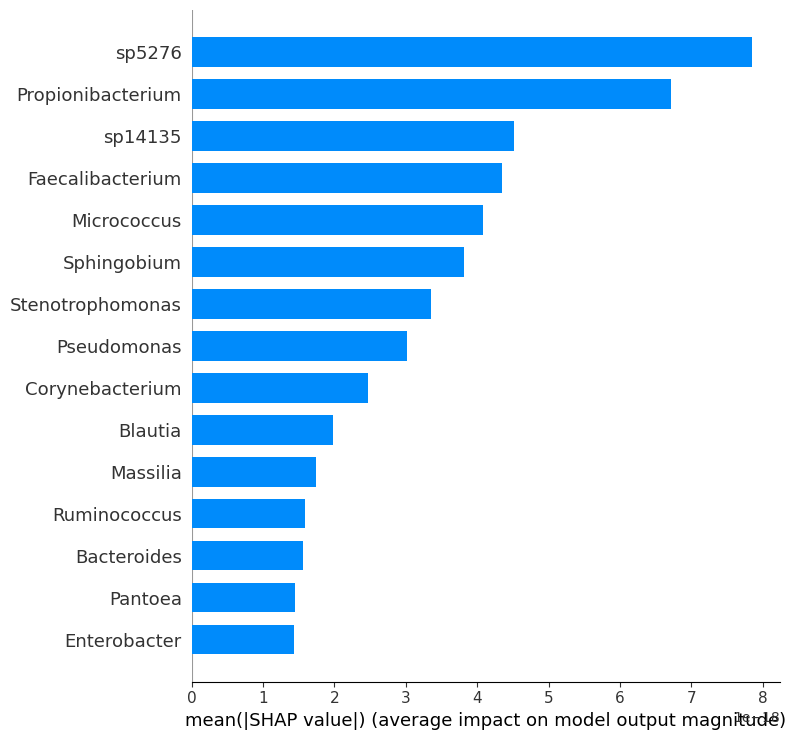

In [23]:
shap.summary_plot(shap_valuesxgb_mean, X, plot_type='bar', max_display=15)

### LightGBM

In [ ]:
clflgbm = LGBMClassifier(random_state=42)
loolgbm = LeaveOneOut()
lgbm_scores = cross_validate(clflgbm, X, y, cv=loolgbm, scoring='accuracy', return_estimator=True)

In [ ]:
lgbm_scores

In [ ]:
for idx, estimator in enumerate(lgbm_scores['estimator']):
    print(f'The most important features for estimator {idx}:')
    feature_importances = pd.DataFrame(estimator.feature_importances_,
                                       index=X.columns,
                                       columns=['Importance']).sort_values('Importance', ascending=False)
    print(feature_importances)



### Multilayer perceptron 

In [ ]:
from sklearn.neural_network import MLPClassifier
clfmlp = MLPClassifier(solver="adam", activation="relu", learning_rate="constant", random_state=42, max_iter=3000, verbose=False)
clfmlp.out_activation_="softmax"

loomlp = LeaveOneOut()
mlp_scores = cross_validate(clfmlp, X, y, cv=loomlp, scoring='accuracy', return_estimator=True)

In [ ]:
mlp_scores

In [ ]:
# Every estimator in mlp_scores need to be fitted and permutation importance run on each estimator.

for idx, estimator in enumerate(mlp_scores['estimator']):
    mlpshap = estimator.fit(X, y)
    result = permutation_importance(mlpshap,X, y,n_repeats=1, random_state = 42)
    MLPfeatures = pd.DataFrame(mlpshap.feature_names_in_,columns=['Features'])
    MLPfeatures['Importance'] = result.importances_mean.tolist()
    #Sort by importance
    MLPfeatures = MLPfeatures.sort_values(by = 'Importance',ascending=False)
    print(f'The most important features for estimator {idx}:')
    print(MLPfeatures)